---
# Notebook for leaf wood segmentation for tropical trees
--- 

## Import libraries

In [3]:
import os
from tqdm import tqdm
import numpy as np
import open3d as o3d
import open3d.ml as _ml3d
import open3d.ml.torch as ml3d
import numpy as np
import glob
import torch

DATA_DIR = "/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/"

## Preprocess dataset

In [3]:
# ---------------
# Code to preprocess the tropical leaf-wood data of Louise Terryn
#
# The manually labeled wood points did not match the original point cloud due to precision mismatch when saving the files.
# I thus saved the original point clouds with the same precision (%.3f). Then, I attributed a label to each point in the 
# original point cloud indicating whether the point is 'wood' or 'non-wood'. 
# 
# ---------------

PATH_TREE = os.path.join(DATA_DIR, 'tree_points')
PATH_WOOD = os.path.join(DATA_DIR, 'wood_points')
plot_names = ['DRO', 'OC', 'RC']

# Create different variables holding the filenames and paths
filenames = {plot_name: os.listdir(os.path.join(PATH_TREE, plot_name)) for plot_name in plot_names}

filenames_all = []
for plot_name in plot_names:
    filenames_all = filenames_all + filenames[plot_name]

filepaths_tree = []
for plot_name in plot_names:
    filepaths_tree = filepaths_tree + [os.path.join(PATH_TREE, plot_name, filename) for filename in filenames[plot_name]]

filepaths_wood = []
for plot_name in plot_names:
    filepaths_wood = filepaths_wood + [os.path.join(PATH_WOOD, plot_name, filename[:-6] + 'tls_0.02_wood.txt') for filename in filenames[plot_name]]


def decrease_precision():

    for file_in, filename_out in zip(filepaths_tree, filenames_all):
        # Read tree
        tree = np.loadtxt(file_in)   

        if not os.path.exists(os.path.join(DATA_DIR, 'tmp')):
                    os.makedirs(os.path.join(DATA_DIR, 'tmp'))

        # Write file with lower precision
        path_out = os.path.join(DATA_DIR, 'tmp', filename_out)
        np.savetxt(path_out, tree, fmt='%.3f')


def view1D(a, b): # a, b are arrays
    a = np.ascontiguousarray(a)
    b = np.ascontiguousarray(b)
    void_dt = np.dtype((np.void, a.dtype.itemsize * a.shape[1]))
    return a.view(void_dt).ravel(),  b.view(void_dt).ravel()


def isin_nd(a,b):
    # a,b are the 3D input arrays to give us "isin-like" functionality across them
    A,B = view1D(a.reshape(a.shape[0],-1),b.reshape(b.shape[0],-1))
    return np.isin(A,B)


def add_label():

     for filename, path_wood in zip(filenames_all, filepaths_wood):
        # Read tree
        tree = np.loadtxt(os.path.join(DATA_DIR, 'tmp', filename)) 
        wood = np.loadtxt(path_wood) 
        wood = wood[:, :3]

        label = isin_nd(tree, wood)
        file_out = np.hstack((tree, label.reshape(-1, 1)))
     
        if not os.path.exists(os.path.join(DATA_DIR, 'preprocessed')):
            os.makedirs(os.path.join(DATA_DIR, 'preprocessed'))
     
        # Write file with label
        path_out = os.path.join(DATA_DIR, 'preprocessed', filename)
        np.savetxt(path_out, file_out, fmt='%.3f')


# decrease_precision()
# add_label()

## Data exploration

In [6]:
DATA_PATH = DATA_DIR + 'preprocessed/'

n_trees = len(os.listdir(DATA_PATH))
print('number of trees:', n_trees)

total_points = 0
wood_points = 0
max_points = 0
min_points = 100000000

for filename in os.listdir(DATA_PATH):
    tree = np.loadtxt(DATA_PATH + filename)
    
    total_points += len(tree)
    wood_points += tree[:, 3].sum()
    max_points = max(max_points, len(tree))
    min_points = min(min_points, len(tree))


print('total number of points:', total_points)
print('average number of points per tree:', total_points / n_trees)
print('max number of points:', max_points)
print('min number of points:', min_points)
print('total number of woody points:', wood_points)
print('total_number of non-wood points:', total_points - wood_points)
print('fraction:', wood_points / total_points)

number of trees: 148
total number of points: 43639363
average number of points per tree: 294860.5608108108
max number of points: 1887667
min number of points: 16484
total number of woody points: 9127323.0
total_number of non-wood points: 34512040.0
fraction: 0.20915344250098242


## 3D deep learning for semantic segmentation

### Load dataset

In [35]:

class MyDataset(torch.utils.data.Dataset):
    """"
    Custom Torch Dataset class to load the point cloud dataset for semantic segmenation into memory

    Attributes:
        data (list): list of  
    """
    def __init__(self, dataset_path):
        self.data = self._load_dataset(dataset_path)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    def _load_dataset(self, dataset_path):
        # Get all filenames of the point clouds (stored as .txt)
        pcd_names = glob.glob(dataset_path + '/*.txt' )

        data = []
        for i in tqdm(range(len(pcd_names)), desc='loading dataset'):
            # Load point cloud
            pcd = np.loadtxt(os.path.join(dataset_path, pcd_names[i]))

            # Append each point cloud as a list
            data.append({
                'point': pcd[:, :3], # xyz coordinates
                'feat': None,        # the points do not have features
                'label': pcd[:, 3].astype(np.int32),  # point wise label
            })
        
        return data
    

DATA_PATH = "/mnt/c/Users/wavdnbro/OneDrive - UGent/Documents/spacetwin/datasets/leaf_wood/preprocessed/"
dataset = MyDataset(DATA_PATH)

# torch_data_train = mydataset(data_train)
# dataload_train = DataLoader(torch_data_train, batch_size=batch_size, shuffle=True, num_workers=2)

loading dataset: 100%|██████████| 148/148 [00:21<00:00,  6.82it/s]


### Explore model

In [ ]:
# Load config file
cfg_file = "cfg/randlanet_leafwood.yml"
cfg = _ml3d.utils.Config.load_from_file(cfg_file)

# Instantiate model and pipeline
model = ml3d.models.RandLANet(**cfg.model)
pipeline = ml3d.pipelines.SemanticSegmentation(model, **cfg.pipeline)

In [34]:
attr = {'split':'train'}
input_pcl = dataset[22]

data = model.preprocess(input_pcl, attr)
inputs = model.transform(data, attr)

print(input_pcl['point'].shape)
print(data['point'].shape)
print(inputs['coords'][0].shape)

# Save preprocessed and transformed point cloud with label
# --> visualise in cloud compare to check. 
# input has been augmented
pcl_transformed = np.hstack((inputs['coords'][0], inputs['labels'].reshape(-1, 1)))
np.savetxt('./tests/pcl_transformed_input_randlanet.txt', pcl_transformed, fmt='%.3f')

(30826, 3)
(30275, 3)
(65536, 3)


In [30]:
np.hstack((inputs['coords'][0], inputs['labels'].reshape(-1, 1)))


array([[ 2.05913281, -0.25518274, 10.0575676 ,  0.        ],
       [ 1.49423504,  1.06055248, 10.02853012,  0.        ],
       [-0.08753002, -1.44900858, 10.19883728,  0.        ],
       ...,
       [-0.5222156 , -0.38171166, 11.84873962,  0.        ],
       [ 0.03200158,  3.0747714 , 12.2192812 ,  0.        ],
       [ 0.3031345 ,  0.12964687,  9.76675892,  1.        ]])

### Inference

In [ ]:
# Run inference
result = pipeline.run_inference(dataset[1])

### Evaluate results

number of points: 735330


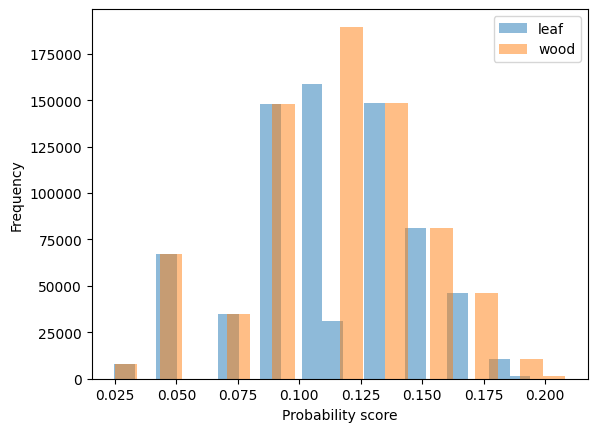

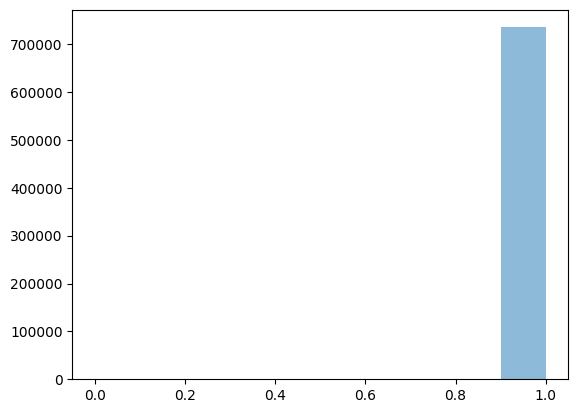

In [37]:
import matplotlib.pyplot as plt

print('number of points:', dataset[1].get('point').shape[0])

scores = result['predict_scores']

plt.hist(scores[:, 0], alpha=0.5, bins=20, label='leaf')
plt.hist(scores[:, 1], alpha=0.5, bins=20, label='wood')

# Add labels and legend
plt.xlabel('Probability score')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

labels = result['predict_labels']

plt.hist(labels, alpha=0.5, label='Column 1')
plt.show()